# Import libraries

In [24]:
import os
import cv2
import numpy as np
from glob import glob
from matplotlib import pyplot as plt

# Blur surroundings to highlight image

In [28]:
base_path = "assets"
blur = (255,255)
# Define per-category sharp region (x, y, w, h)
CROP_REGIONS = {
    "knife":  (450, 500, 1800, 800),
    "marine": (900, 180, 800, 2000)
}

categories = ["knife", "marine"]

def blur_background_keep_center(image_path, output_path, region):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not read {image_path}")
        return

    x, y, w, h = region
    h_img, w_img = img.shape[:2]

    # Safety clipping
    x = max(0, x)
    y = max(0, y)
    w = min(w, w_img - x)
    h = min(h, h_img - y)

    # Blur entire image
    blurred = cv2.GaussianBlur(img, blur, 0)

    # Paste back sharp central region
    blurred[y:y+h, x:x+w] = img[y:y+h, x:x+w]

    success = cv2.imwrite(output_path, blurred)
    if not success:
        #print(f"Failed to save {output_path}")
        pass
    else:
        #print(f"Saved: {output_path}")
        pass

for category in categories:
    src_dir = os.path.join(base_path, category, "images_raw")
    tgt_dir = os.path.join(base_path, category, "images_clean")
    os.makedirs(tgt_dir, exist_ok=True)

    image_paths = sorted(glob(os.path.join(src_dir, "*.png")))
    region = CROP_REGIONS[category]
    print(f"\n{category.upper()}: {len(image_paths)} images with region {region}")

    for img_path in image_paths:
        filename = os.path.basename(img_path)
        out_path = os.path.join(tgt_dir, filename)
        blur_background_keep_center(img_path, out_path, region)

print("\n All background-blurred images saved to 'images_clean'")



KNIFE: 19 images with region (450, 500, 1800, 800)

MARINE: 14 images with region (900, 180, 800, 2000)

 All background-blurred images saved to 'images_clean'


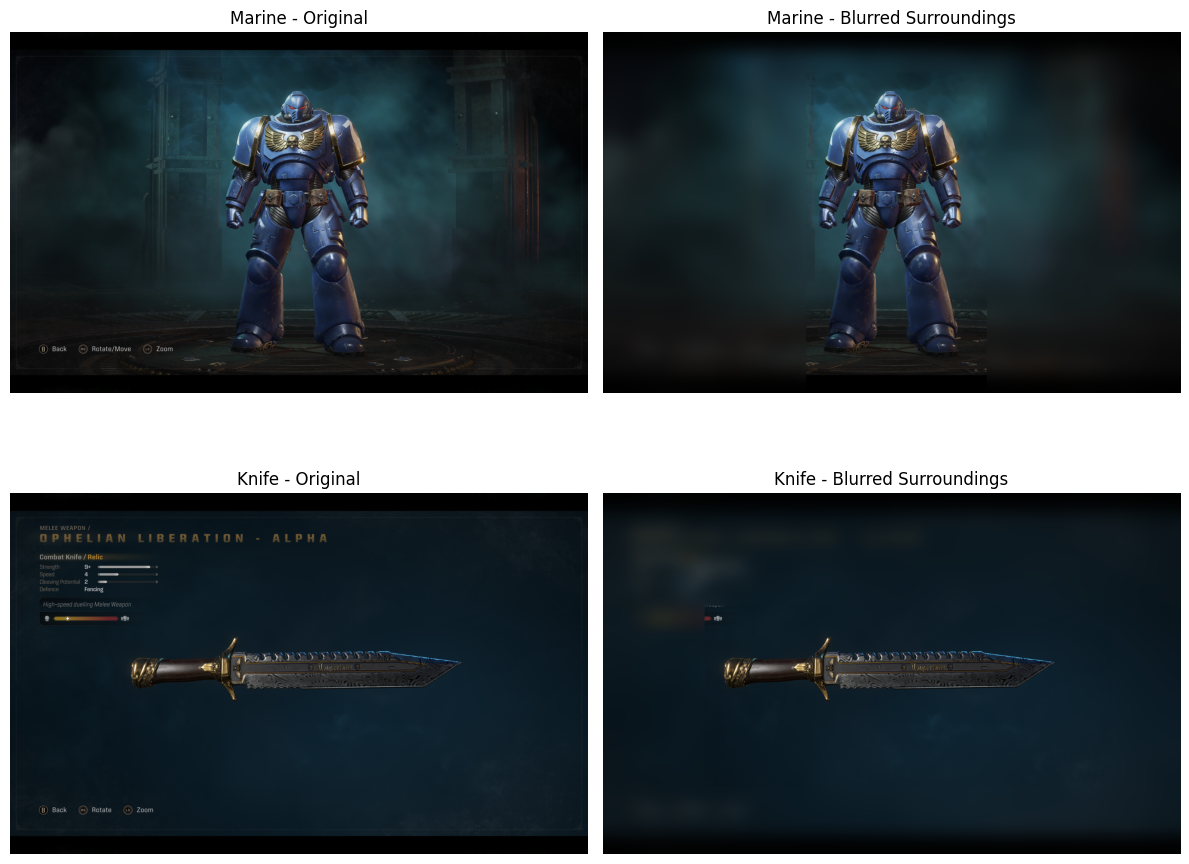

In [31]:
import cv2
import matplotlib.pyplot as plt

def load_and_convert(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if img is not None else None

# Paths
marine_raw     = "assets/marine/images_raw/Screenshot 2025-07-15 123438.png"
marine_clean   = "assets/marine/images_clean/Screenshot 2025-07-15 123438.png"
knife_raw      = "assets/knife/images_raw/Screenshot 2025-07-15 124648.png"
knife_clean    = "assets/knife/images_clean/Screenshot 2025-07-15 124648.png"

# Load images
marine_orig  = load_and_convert(marine_raw)
marine_blur  = load_and_convert(marine_clean)
knife_orig   = load_and_convert(knife_raw)
knife_blur   = load_and_convert(knife_clean)

# Plot side-by-side comparisons
plt.figure(figsize=(12, 10))

# Marine
plt.subplot(2, 2, 1)
plt.title("Marine - Original")
plt.imshow(marine_orig)
plt.axis("off")

plt.subplot(2, 2, 2)
plt.title("Marine - Blurred Surroundings")
plt.imshow(marine_blur)
plt.axis("off")

# Knife
plt.subplot(2, 2, 3)
plt.title("Knife - Original")
plt.imshow(knife_orig)
plt.axis("off")

plt.subplot(2, 2, 4)
plt.title("Knife - Blurred Surroundings")
plt.imshow(knife_blur)
plt.axis("off")

plt.tight_layout()
plt.show()


# Apply noise

In [30]:
import cv2
import numpy as np

def degrade_image(image, blur_strength=3, noise_std=10, haze_strength=0.4, color_shift=True):
    """
    Simulate underwater-like degradation on an image.
    
    Parameters:
    - image: Input image as a NumPy array (BGR format).
    - blur_strength: Kernel size for Gaussian blur (must be odd).
    - noise_std: Standard deviation of Gaussian noise (0–50 typical).
    - haze_strength: Factor for contrast loss (0–1), higher = hazier.
    - color_shift: If True, add a blue/green underwater tint.

    Returns:
    - Degraded image.
    """

    # Apply Gaussian blur
    if blur_strength > 0:
        image = cv2.GaussianBlur(image, (blur_strength, blur_strength), 0)

    # Add Gaussian noise
    noise = np.random.normal(0, noise_std, image.shape).astype(np.float32)
    noisy_image = np.clip(image.astype(np.float32) + noise, 0, 255).astype(np.uint8)

    # Simulate haze (reduce contrast and increase brightness)
    hazy_image = cv2.addWeighted(noisy_image, 1 - haze_strength, np.full_like(noisy_image, 255), haze_strength, 0)

    # Simulate underwater color cast
    if color_shift:
        b, g, r = cv2.split(hazy_image)
        r = cv2.multiply(r, 0.6)  # Red gets absorbed quickly in water
        g = cv2.multiply(g, 0.9)
        degraded = cv2.merge((b, g, r))
    else:
        degraded = hazy_image

    return degraded
